<a href="https://colab.research.google.com/github/cdr6934/UnsupervisedLearningFinal/blob/main/MSDS_FInal_Project_Women's_Clothing_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Review Topic from Women's Clothing Review Data
##DTSA 5510 Unsupervised Algorithms in Machine Learning
3/3/2024 for UoC at Boulder


## Problem Description

The purpose of this project was to create a classifer based on a unsupervised topic model. In this case we took women's clothing reviews, created an LDA topic model, used these topics to intuitively classify the types of reviews and then create a classifer off these reviews. This would provide a way to triage the types of reviews without having to recreate the topic model on the entire dataset.

The use cases for this is to quickly identify the type of review that has been given to a particular product. In this case we see the following topics that were inferred by the model we ran.


| Topic | Description | Example |
|---|---| --- |
| 1_size | Size or Fit of clothing | ... color different vibrant chose size extra room length .. |
| 2_wear | Wearability of the clothing (comfort) | ...i love that i can wear this with leggings and sandals in warm weather or boots and scarves when it's cooler outside... |
| 3_look |features of the clothing (color, style)| ... flattering cut. great with flats, wedges, booties, boots with tights. ... |
| 4_dress | Features of the dress (color, style) | ... Soft and cozy, the orange is vibrant, the green is more subtle and has gray tones.... |
| 5_pant | Reviews mentioning specifically the pant of an outfit | ... The wide leg was fun, not too wide, but the long pocket seem to shorten leg so i returned. .. |

After trying to find an interesting dataset on Harvard Dataverse, I ended up going to Kaggle to pickup a dataset of reviews on women's clothing. My first  objective was to use the reviews text and compare how I can use the text to classify against more common supervised learning and see if we can infer the ratings of these products based on product type.

We covered a number of new methodologies
* SMOTE Balancing
* LDA - Latent Dirichlet Allocation
* Gensim Multi-LDA implementation

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall -y numba
!pip uninstall -y tensorflow
!pip install lda
!pip install "tmtoolkit[recommended]"

In [317]:
try:
  from lda import LDA
except:
  !pip install lda
  from lda import LDA


# Import pyLDAvis or install
try:
  import pyLDAvis
except:
  !pip install pyLDAvis
  import pyLDAvis



In [55]:
import gzip
import itertools
import json
import os
from textblob import TextBlob
import pickle
import subprocess
import string


# Data processing
import numpy as np
import pandas as pd

# Text processing
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, remove_punctuation, filter_clean_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened, print_summary
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import vocabulary
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from string import punctuation
from nltk.corpus import stopwords


from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle
from tmtoolkit.topicmod.visualize import parameters_for_ldavis


# SKLEARN processes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from collections import namedtuple
from math import sqrt
import tqdm # time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Used to download the NLTK models which we are going to use to clean the data.
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('wordnet.zip')
    nltk.data.find('punkt')
    nltk.data.find('stopwords')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('stopwords', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    nltk.download('punkt')
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## EDA (Exploratory Data Analysis)


* Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.

* Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

* Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

* Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.

* You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?

* If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.

## Data
The data is hosted on [Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews).

Based on the data card on Kaggle; I've renamed the columns see the parenthesis to make it easier when working with them.


This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

* Clothing ID (clothing_id): Integer Categorical variable that refers to the specific piece being reviewed.
* Age (age): Positive Integer variable of the reviewers age.
* Title (title): String variable for the title of the review.
* Review Text (review_text): String variable for the review body.
* Rating (rating): Positive Ordinzal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
* Recommended IND (recommended_idx): Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
* Positive Feedback Count (positive_feedback_cnt): Positive Integer documenting the number of other customers who found this review positive.
* Division Name (division_name): Categorical name of the product high level division.
* Department Name (department_name): Categorical name of the product department name.
* Class Name (class_name): Categorical name of the product class name.


In [9]:
data_filename = '/content/drive/MyDrive/MSDSUnsupervisedMachineLearning_Final/ecommerce_reviews_data.csv'
data = pd.read_csv(data_filename)

In [10]:
data.head()

,clothing_id,age,title,review_text,rating,recommended_idx,positive_feedback_cnt,division_name,department_name,class_name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


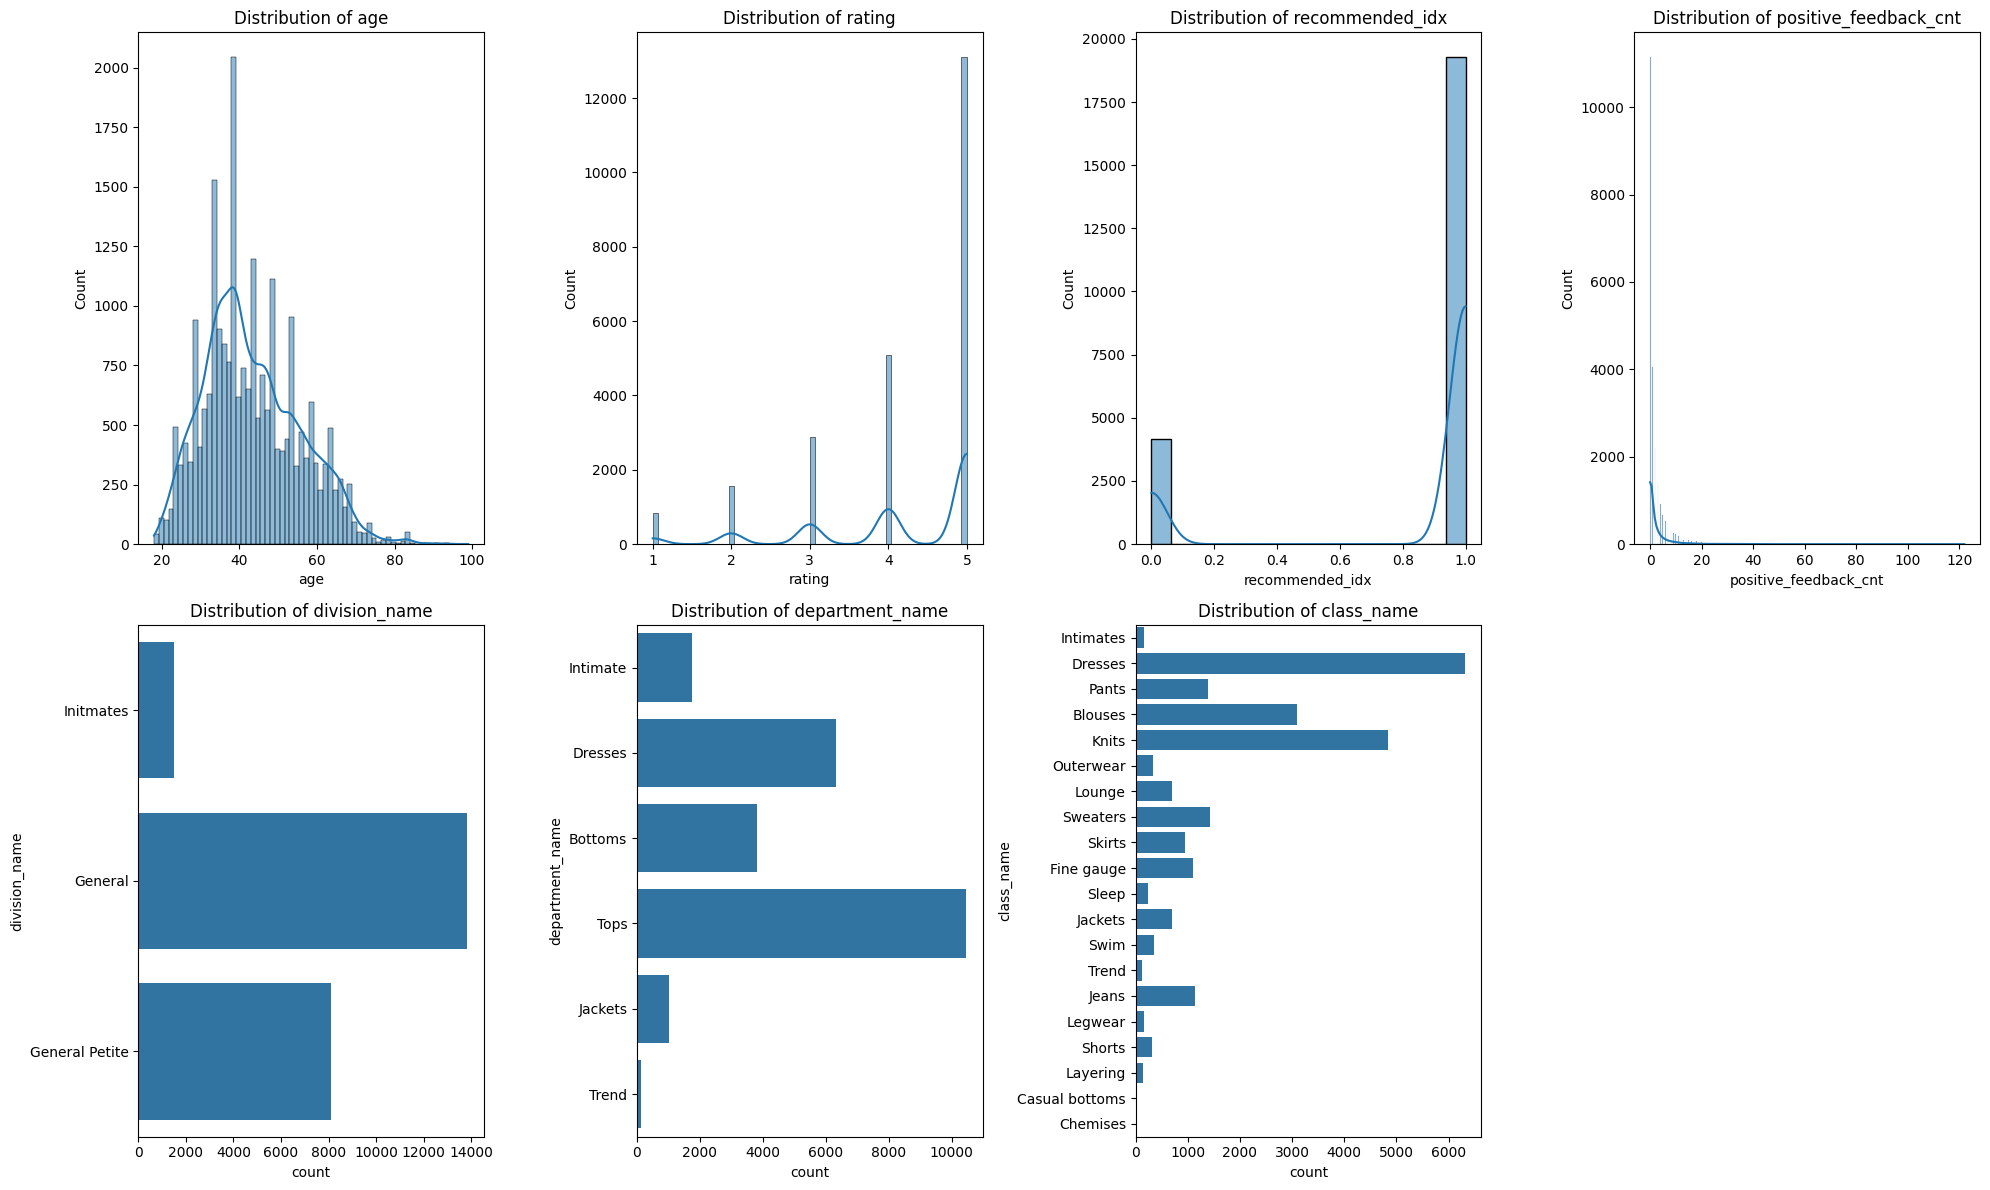

In [338]:

# Setting up the figure size and layout for the panel
plt.figure(figsize=(20, 12))

# Numerical features
numerical_features = ['age', 'rating', 'recommended_idx', 'positive_feedback_cnt']
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# Factor variables
factor_variables = ['division_name', 'department_name', 'class_name']
for i, factor in enumerate(factor_variables, 1):
    plt.subplot(2, 4, i + 4)  # Adjusting index to place these plots in the second row
    sns.countplot(y=data[factor])
    plt.title(f'Distribution of {factor}')


plt.tight_layout()
plt.show()

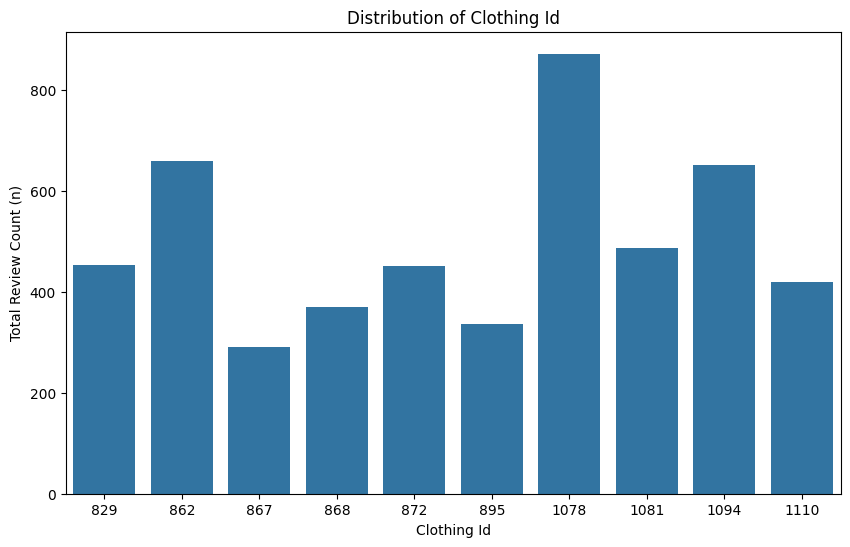

In [12]:
# Preparing data for the top 10 clothing_ids
plt.figure(figsize=(10, 6))

df_top_10_clothing=data.groupby(by=['clothing_id'])['title'].count().reset_index(name='TotalCnt')
df_top_10_clothing = df_top_10_clothing.sort_values('TotalCnt', ascending=False).head(10)
#df_top_10_clothing_ids = df_top_10_clothing_ids.sort_values('count', ascending=False)
df_top_10_clothing = df_top_10_clothing.sort_values('TotalCnt', ascending=False)
g = sns.barplot(x='clothing_id', y='TotalCnt', data=df_top_10_clothing)
plt.title('Distribution of Clothing Id')
plt.xlabel('Clothing Id')
plt.ylabel('Total Review Count (n)')
plt.show()

### Correlation Analysis

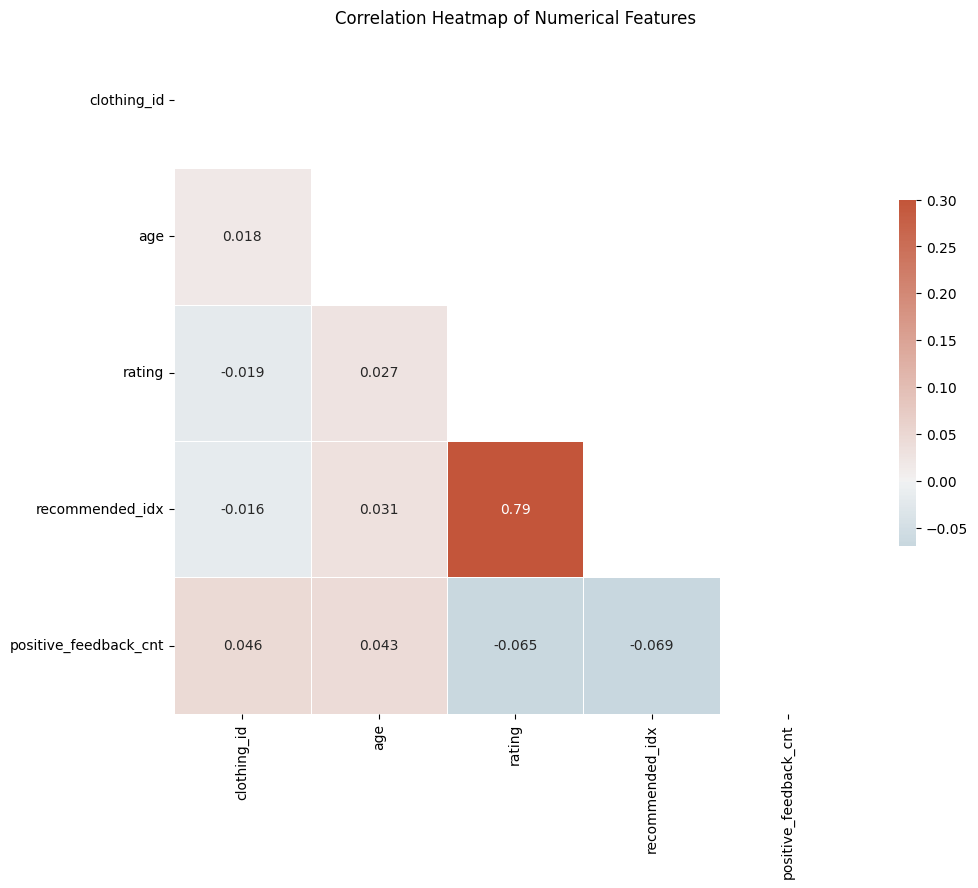

In [13]:


# Compute the correlation matrix for numerical features
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Heatmap of Numerical Features')
plt.show()


On the correlations between these features, we see that the highest correlation is between the the following:

* recommended_idx and rating... this would make sense as the recommended boolean here would be 1 if it is greater than (assume the average) of 2.5 so all items where the rating is above 3, we should see this to be a 1.
* As for the rest of the counts, we see there to be very little correlation between any of the other features. (those features being as close as not correlated as it would get. (0.04 to -0.08)
* As there is very little correlation, this will help when creating a number of different linear regression like algorithms.



### Data Cleansing
* Ensure the typing of the columns
* Checking for nulls
* Splitting the data into test and training sets

#### Correct data types

Here we are just inferring that the review_text has been typed correctly.

In [14]:
data['review_text'] = data['review_text'].astype(str)

#### Checking for duplicates and nulls
Here we are able to remove a few duplicates that are in the data. As for the nulls, we have pulled out the information.

In [15]:

# Drop duplicates
duplicates = data.duplicated().sum()
data.drop_duplicates(inplace=True)

# Check out for nulls
nulls = data.isnull().sum()
nulls

clothing_id                 0
age                         0
title                    3789
review_text                 0
rating                      0
recommended_idx             0
positive_feedback_cnt       0
division_name              14
department_name            14
class_name                 14
dtype: int64

#### NLP Data Cleaning

In [16]:
stopwords = stopwords.words('english')

def clean_text(doc):
    text = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    tokens = nltk.word_tokenize(text.lower())
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    return ' '.join(tokens)

data['clean_text'] = data['review_text'].apply(lambda x: clean_text(x))

In [17]:
data[['review_text', 'clean_text']].head()

,review_text,clean_text
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store im ...
2,I had such high hopes for this dress and reall...,high hope dress really wanted work initially o...
3,"I love, love, love this jumpsuit. it's fun, fl...",love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...


### Splitting the data

In [264]:
X = data.drop(columns=['rating'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 241)

### TF_IDF Vectorizer

In order to take the review_text we need to use a vectorizer which will give us a sparse matrix of the clean text above which then can be fed into any model due to the encoding of the data.

Specifically TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a widely used technique in the field of natural language processing (NLP) and information retrieval. Its primary purpose is to convert textual data into a numerical format, making it suitable for machine learning algorithms. TF-IDF itself is a statistical measure used to evaluate how important a word is to a document in a collection or corpus of documents.

In [265]:
#create vectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')


tfidvec_train = tfidvec.fit_transform(X_train['clean_text'])
tfidvec_test = tfidvec.transform(X_test['clean_text'])

## Model Building / Analysis

### Random Forest
Random Forests are a popular ensemble learning technique capable of performing both classification and regression tasks. They are an extension of decision trees and operate by constructing a multitude of decision trees at training time to output either the mode of the classes for classification tasks or the mean prediction of the individual trees for regression tasks.

The Random Forest is such a great way to get a quick model that we can use to evaluate the performance of the dataset based on the output.

In [266]:

# Use the following to print function
def print_table(gs_cv_results):
  results_df = pd.DataFrame(gs_cv_results.cv_results_)

  # Select and rename the relevant columns
  relevant_columns = ['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score']
  results_df = results_df[relevant_columns]
  results_df.rename(columns={
      'param_max_depth': 'Max Depth',
      'param_min_samples_split': 'Min Samples Split',
      'param_n_estimators': 'N Estimators',
      'mean_test_score': 'Test Score'
  }, inplace=True)

  # Display the table
  return results_df

Used grid search to try and find an ideal model that would work well.

In [267]:
# random forest

# grid search for rf
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [ 75],
    'min_samples_split': [20],
}

def rf_classifer(X, y, grid_param):
  rf= RandomForestClassifier()
  grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
  grid_search.fit(X, y)
  return grid_search

# Object of models
unbalanced_rf_models = rf_classifer(tfidvec_train, y_train, param_grid)
best_rf_model = unbalanced_rf_models.best_estimator_

In [268]:
print_table(unbalanced_rf_models)


,Max Depth,Min Samples Split,N Estimators,Test Score
0,75,20,50,0.573247
1,75,20,100,0.573194
2,75,20,150,0.573993
3,75,20,200,0.571809


In [310]:
# Get the best hyperparameters
best_params = unbalanced_rf_models.best_params_
print(best_params)

{'max_depth': 75, 'min_samples_split': 20, 'n_estimators': 150}


In [311]:

res = best_rf_model.predict(tfidvec_test)
X_test_res_unbal = X_test
X_test_res_unbal['y_test'] = y_test
X_test_res_unbal['y_pred'] = res


# Calculate the accuracy
accuracy = accuracy_score(X_test_res_unbal['y_test'], X_test_res_unbal['y_pred'])
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58


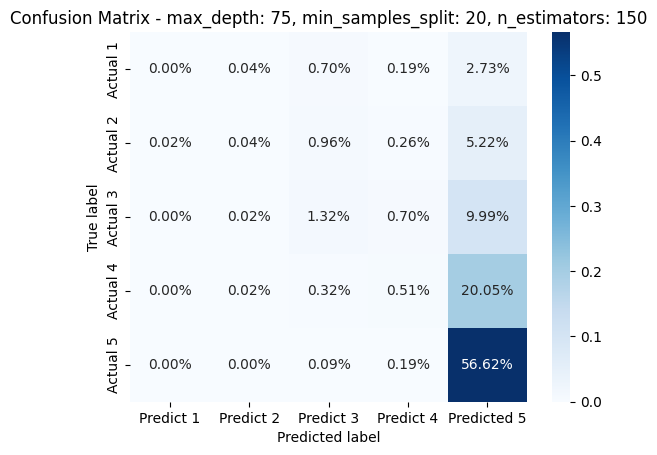

In [312]:
cm_unbal = confusion_matrix(X_test_res_unbal['y_test'], X_test_res_unbal['y_pred'])

cm_unbal_pct = (cm_unbal.astype('float') / np.sum(cm_unbal))

sns.heatmap(cm_unbal_pct, annot=True, fmt=".2%",   cmap="Blues",
            xticklabels=["Predict 1", "Predict 2", "Predict 3", "Predict 4", "Predicted 5"],
            yticklabels=["Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - max_depth: 75, min_samples_split: 20, n_estimators: 150')
plt.show()

In [270]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [271]:

## This is using the balanced data to try and understand the information
# grid search for rf
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [75],
    'min_samples_split': [20],
}

# Object of models
balanced_rf_models = rf_classifer(X_train_balanced, y_train_balanced, param_grid)
best_balanced_rf_model = balanced_rf_models.best_estimator_

In [272]:
print_table(balanced_rf_models)

,Max Depth,Min Samples Split,N Estimators,Test Score
0,75,20,50,0.865052
1,75,20,100,0.874457
2,75,20,150,0.876411
3,75,20,200,0.878384


In [313]:
# Run prediction
res = best_balanced_rf_model.predict(tfidvec_test)
X_test_res = X_test
X_test_res['y_test'] = y_test
X_test_res['y_pred'] = res

# Calculate the accuracy
accuracy = accuracy_score(X_test_res_unbal['y_test'], X_test_res_unbal['y_pred'])
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


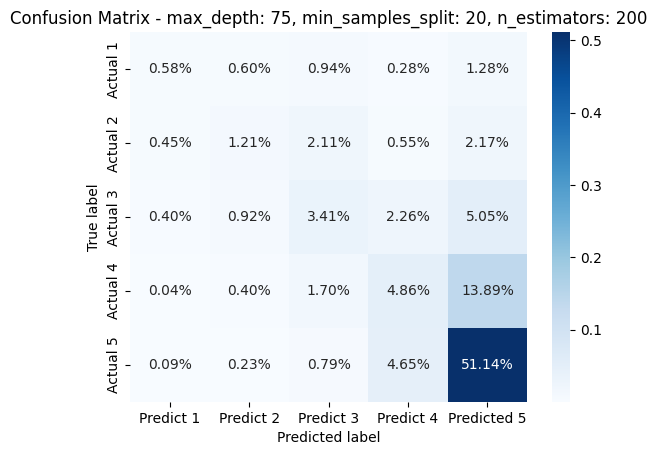

In [314]:
cm = confusion_matrix(X_test_res['y_test'], X_test_res['y_pred'])

total = np.sum(cm)
cm_percentage = (cm.astype('float') / total)

sns.heatmap(cm_percentage, annot=True, fmt=".2%",  cmap="Blues",
            xticklabels=["Predict 1", "Predict 2", "Predict 3", "Predict 4", "Predicted 5"],
            yticklabels=["Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - max_depth: 75, min_samples_split: 20, n_estimators: 200')
plt.show()

### LDA -  Latent Dirichlet Allocation (Unsupervised Method)

Latent Dirichlet Allocation (LDA) is a type of probabilistic topic model that is widely used in natural language processing (NLP) and machine learning to classify text in a document to a particular topic. It helps in discovering abstract topics from a collection of documents, where each document can be considered a mixture of various topics. Here's an overview of LDA focusing on its key concepts, how it works, and its applications:

### Gensim Multi-LDA Implementation

Coherence, in the context of Latent Dirichlet Allocation (LDA), is a metric used to evaluate the quality of the topics generated by the model. LDA is a popular topic modeling technique that identifies topics within a collection of documents, where each topic is characterized by a distribution over words. However, determining the number of topics that best represents the data is not straightforward, and evaluating the interpretability of these topics can be subjective. This is where coherence measures come into play.

In [163]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import tqdm # time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_list = data['clean_text']
data_lst = data_list.values.tolist()
data_words = list(sent_to_words(data_lst))


In [164]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [177]:
grid = {}
grid['Validation_Set'] = {}


topics_range = [5]
alpha = [0.1, 0.3, 0.7]
beta = [0.5,1]

# Validation sets
num_of_docs = len(corpus)
corpus_sets = corpus

corpus_title = '100% Corpus'

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
gensim_models = []

if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)))
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets, dictionary=id2word,
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                gensim_models.append(model_results)
                pbar.update(1)
    #pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 4/4 [11:19<00:00, 169.78s/it]


In [124]:
pd.DataFrame(model_results)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,5,0.1,0.5,0.372399
1,75% Corpus,5,0.1,1.0,0.500264
2,75% Corpus,5,0.3,0.5,0.388201
3,75% Corpus,5,0.3,1.0,0.401564
4,75% Corpus,5,0.5,0.5,0.423951
5,75% Corpus,5,0.5,1.0,0.357867
6,75% Corpus,5,0.7,0.5,0.439365
7,75% Corpus,5,0.7,1.0,0.439732
8,100% Corpus,5,0.1,0.5,0.345295
9,100% Corpus,5,0.1,1.0,0.475155


In [178]:
pd.DataFrame(model_results)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,10,0.1,0.5,0.331802
1,100% Corpus,10,0.1,1.0,0.415138
2,100% Corpus,15,0.1,0.5,0.414420
3,100% Corpus,15,0.1,1.0,0.371426


In [126]:
best_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           eta=1.0)

### Build Corpus
This really is a preprocessing step of the data.. we need to ensure that the

In [ ]:
def build_corpus(texts, lang="en"):

    # Here, we just use the index of the text as the label for the corpus item
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)
    return corpus

reviews_corpus = build_corpus(data['clean_text']) # create the corpus

'''
file_save_location = "/content/drive/MyDrive/msds_topical_final_project/MSDS_HW2_corpus.p"
with open(file_save_location, "rb") as corpusfile:
    corpus = pickle.load(reviews_corpus)
'''

### LDA Modelling


In [ ]:
model_dt = best_lda_model
vocab_dt = vocab
dtm_dt = dtms['reviews_corpus']
doc_labels = reviews_corpus.doc_labels


ldavis_params = parameters_for_ldavis(
    model_dt.topic_word_,
    model_dt.doc_topic_,
    dtm_dt,
    vocab_dt
)

In [152]:
dtms = { "reviews_corpus": dtm(reviews_corpus)}

lda_params = {
    'n_topics': 5,
    'eta': 1,
    'n_iter': 500,
    'random_state': 1234,  # to make results reproducible
    'alpha': 0.1
}

# Models
models = compute_models_parallel(dtms, constant_parameters=lda_params)
model = models["reviews_corpus"][0][1]

# Model Play
model_dt = model
vocab_dt = vocabulary(reviews_corpus)
dtm_dt = dtms['reviews_corpus']
doc_labels = reviews_corpus.doc_labels

topic_word = model.topic_word_
n_top_words = 10
vocab = vocabulary(reviews_corpus)

for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
  print('Topic {}: {}'.format(i+1, ' '.join(topic_words)))


Topic 1: size fit small order love wear like color large
Topic 2: wear love dress great color fit look perfect comfortable
Topic 3: look like color sweater fabric love shirt wear think
Topic 4: dress fit size look like love fabric wear waist
Topic 5: pant jean nan wash pair love wear fit leg


In [153]:
# if loaded from file
model_dt = model
vocab_dt = vocab
dtm_dt = dtms['reviews_corpus']
doc_labels = reviews_corpus.doc_labels

# generate topic labels
topic_labels = generate_topic_labels_from_top_words(
    model_dt.topic_word_,
    model_dt.doc_topic_,
    doc_lengths(dtm_dt),
    np.array(vocab_dt),
)

doc_topic = model.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic, doc_labels, top_n=2, topic_labels=topic_labels)

In [323]:
documentclassifications['rank'] = documentclassifications['rank_1'].str.extract(r'(^\S+)')
documentclassifications['review_type'] = documentclassifications['rank_1'].str[0]
documentclassifications

,rank_1,rank_2,rank,review_type
document,,,,
0,2_wear (0.9273),5_pant (0.01818),2_wear,2
1,4_dress (0.9429),2_wear (0.0449),4_dress,4
2,4_dress (0.8458),1_size (0.147),4_dress,4
3,2_wear (0.9652),5_pant (0.008696),2_wear,2
4,2_wear (0.8963),3_look (0.08148),2_wear,2
...,...,...,...,...
23460,2_wear (0.9652),5_pant (0.008696),2_wear,2
23461,1_size (0.8341),3_look (0.1512),1_size,1
23462,1_size (0.9652),5_pant (0.008696),1_size,1


In [155]:
# Move the data to separate df
data_check = data
data_check['rank'] = documentclassifications['rank']

In [156]:
crosstab = pd.crosstab(data_check['rating'], data_check['rank'])


rank,1_size,2_wear,3_look,4_dress,5_pant
rating,,,,,
1,230,208,137,209,57
2,416,401,213,421,114
3,732,740,366,814,215
4,1347,1320,700,1339,365
5,3492,3491,1785,3358,975


In [219]:
# Move the data to separate df
data_check = data
data_check['rank'] = documentclassifications['rank']
data_check['review_text'] = data['review_text']


In [344]:
topics = data_check['rank'].unique()
sampled_data = pd.DataFrame()

for topic in topics:

  try:
    test_text = data_check[data_check['rank'] == topic]
    sampled_data = sampled_data.append(test_text.sample(n=10), ignore_index=True)
  except:
    print('issue occured')
sampled_data

issue occured


,clothing_id,age,title,review_text,rating,recommended_idx,positive_feedback_cnt,division_name,department_name,class_name,clean_text,rank,review_type
0,868,61,Very stylish but made with cheap fabric,I love the design of this tunic. it is sewn we...,3,0,2,General,Tops,Knits,love design tunic sewn well fabric cheap disli...,2_wear,2
1,872,50,NaN,One of the most comfortable tops i own. fits l...,5,1,0,General,Tops,Knits,one comfortable top fit loose soft fabric look...,2_wear,2
2,1110,68,You will feel so elegant!,"As part of the over 60 crowd, i rarely wear dr...",5,1,0,General,Dresses,Dresses,part crowd rarely wear dress called didnt disa...,2_wear,2
3,1004,50,"Amazing quality, beautiful design",I absolutely loved this the minute i saw it. t...,5,1,5,General,Bottoms,Skirts,absolutely loved minute saw quality impeccable...,2_wear,2
4,946,34,Beautiful surpise backless sweater,Always looking for sweaters that are wearable ...,5,1,0,General,Tops,Sweaters,always looking sweater wearable south florida ...,2_wear,2
5,895,63,Love this sweater in black,Very nicely made sweater which fits well. i bo...,5,1,1,General Petite,Tops,Fine gauge,nicely made sweater fit well bought black whit...,2_wear,2
6,862,28,Too pricey for the product,I like this top. i received a ton of complimen...,4,0,9,General,Tops,Knits,like top received ton compliment wore work mat...,2_wear,2
7,936,53,Colors are very pretty...,This duster is very nicely put together and is...,4,1,0,General Petite,Tops,Sweaters,duster nicely put together midweight im sure w...,2_wear,2
8,928,37,NaN,Stunning cardigan--i love it :) they only had ...,5,1,0,General,Tops,Sweaters,stunning cardigani love size l sale purchasedi...,2_wear,2
9,942,54,Endless possibilities,My imagination went wilt with all of the possi...,5,1,0,General,Tops,Sweaters,imagination went wilt possible combination ves...,2_wear,2


| Rating | Description | Example |
|---|---| --- |
| 1_size | Size or Fit of clothing | ... color different vibrant chose size extra room length .. |
| 2_wear | Wearability of the clothing (comfort | ...i love that i can wear this with leggings and sandals in warm weather or boots and scarves when it's cooler outside... |
| 3_look |features of the clothing (color, style)| ... flattering cut. great with flats, wedges, booties, boots with tights. ... |
| 4_dress | Features of the dress (color, style) | ... Soft and cozy, the orange is vibrant, the green is more subtle and has gray tones.... |
| 5_pant | Reviews mentioning specifically the pant of an outfit | ... The wide leg was fun, not too wide, but the long pocket seem to shorten leg so i returned. .. |

## Random Forest w/ LDA Topic Modelling

Now that we built the topic model, we want to use the topics and create a classifer with these topics.

In [332]:
# Split data
data_review = data
data_review['review_type'] = documentclassifications['review_type']
X_review = data_review.drop(columns=['rating'])
y_review = data_review['rating']
X_train_review, X_test_review, y_train_review, y_test_review = train_test_split(X_review,y_review, test_size = 0.2, random_state = 241)

In [333]:
#create vectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')


tfidvec_train_review = tfidvec.fit_transform(X_train_review['clean_text'])
tfidvec_test_review = tfidvec.transform(X_test_review['clean_text'])

In [334]:

# grid search for rf
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [75,100],
    'min_samples_split': [20, 40],
}

def rf_classifer(X, y, grid_param):
  rf= RandomForestClassifier()
  grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
  grid_search.fit(X, y)
  return grid_search

# Object of models
unbalanced_rf_models = rf_classifer(tfidvec_train_review, y_train_review, param_grid)
best_rf_model_review = unbalanced_rf_models.best_estimator_

In [335]:
print_table(unbalanced_rf_models)

,Max Depth,Min Samples Split,N Estimators,Test Score
0,75,20,50,0.576124
1,75,20,100,0.574313
2,75,40,50,0.571223
3,75,40,100,0.571170
4,100,20,50,0.579640
5,100,20,100,0.576497
6,100,40,50,0.575058
7,100,40,100,0.572608


In [336]:
# Run against test data
res = best_rf_model.predict(tfidvec_test)
X_test_res_unbal_review = X_test_review
X_test_res_unbal_review['y_test'] = y_test_review
X_test_res_unbal_review['y_pred'] = res


# Calculate the accuracy
accuracy = accuracy_score(X_test_res_unbal_review['y_test'], X_test_res_unbal_review['y_pred'])
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.58


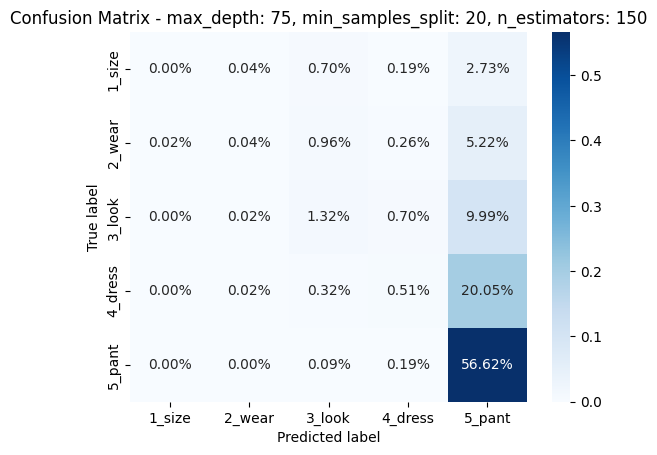

In [337]:

cm_unbal_review = confusion_matrix(X_test_res_unbal_review['y_test'], X_test_res_unbal_review['y_pred'])

cm_unbal_pct_review = (cm_unbal_review.astype('float') / np.sum(cm_unbal_review))

sns.heatmap(cm_unbal_pct_review, annot=True, fmt=".2%",   cmap="Blues",
            xticklabels=["1_size", "2_wear", "3_look", "4_dress", "5_pant"],
            yticklabels=["1_size", "2_wear", "3_look", "4_dress", "5_pant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - max_depth: 75, min_samples_split: 20, n_estimators: 150')
plt.show()

In [349]:
smote = SMOTE(random_state=42)
X_train_review_balanced, y_train_review_balanced = smote.fit_resample(tfidvec_train_review, y_train_review)

## This is using the balanced data to try and understand the information
# grid search for rf
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [75],
    'min_samples_split': [20],
}

# Object of models
balanced_review_rf_models = rf_classifer(X_train_review_balanced, y_train_review_balanced, param_grid)
best_balanced_review_rf_model = balanced_review_rf_models.best_estimator_

In [352]:
print_table(balanced_review_rf_models)

,Max Depth,Min Samples Split,N Estimators,Test Score
0,75,20,50,0.864056
1,75,20,100,0.873155
2,75,20,150,0.876335
3,75,20,200,0.877561


In [350]:

res = best_balanced_review_rf_model.predict(tfidvec_test)
X_test_res_review_balanced = X_test
X_test_res_review_balanced['y_test'] = y_test
X_test_res_review_balanced['y_pred'] = res


# Calculate the accuracy
accuracy = accuracy_score(X_test_res_review_balanced['y_test'], X_test_res_review_balanced['y_pred'])
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


## Results

I started with trying to see if I couldn't use LDA to create a topic model that might infer the recommendations from the dataset. So first I used Gensum.MultLDA implimentation and optimized to the coherence by using Gridsearch a number of different parameters to better understand the differences between

### Predicting Ratings based on Review using TFID Embedding
Using only the vectorized review data, we see that the following results

| Type | Score (Train) | Score Train |
|---|---|--- |
| unbalanced  | 0.574 | 0.58 |
| balanced (SMOTE)  | 0.878| 0.61|




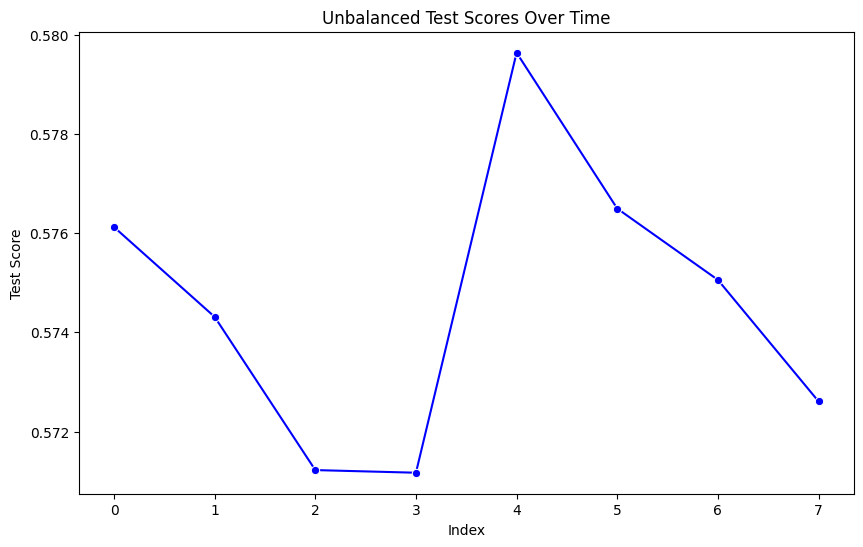

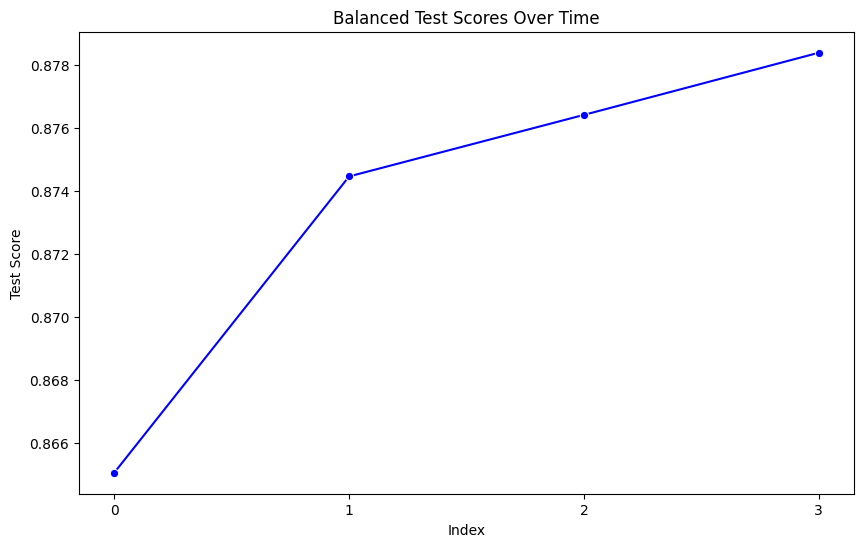

In [341]:
# Plotting
unbalanced_tbl = print_table(unbalanced_rf_models)
balanced_tbl = print_table(balanced_rf_models)

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
sns.lineplot(data=unbalanced_tbl, x=unbalanced_tbl.index, y='Test Score', marker='o', color='b', sort=False)

plt.title('Unbalanced Test Scores Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Test Score')  # Y-axis label
plt.xticks(unbalanced_tbl.index)  # Set x-ticks to match the DataFrame index, if needed

plt.show()  # Display the plot

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
sns.lineplot(data=balanced_tbl, x=balanced_tbl.index, y='Test Score', marker='o', color='b', sort=False)
plt.title('Balanced Test Scores Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Test Score')  # Y-axis label
plt.xticks(balanced_tbl.index)  # Set x-ticks to match the DataFrame index, if needed

plt.show()  # Display the plot

### Creating a Topic Model using Multi-LDA
Using the coherence metric, we are able to determine the parameters to get a best suited topic model. Based on the review information, we ended us

|Validation_Set|	Topics|	Alpha|	Beta|	Coherence|
|---|---|---|---|----|
|1|	75% Corpus|	5	|0.1	|1.0	|0.500264|  

The topic selection ended up being 5 as it corresponding to the (1-5) rating which was built on the RF models we looked at above. Following we see the topics; which I went through about 10 reviews of each that were randomly selected and interpreted the resulting topics.

| Topic | Description | Example |
|---|---| --- |
| 1_size | Size or Fit of clothing | ... color different vibrant chose size extra room length .. |
| 2_wear | Wearability of the clothing (comfort) | ...i love that i can wear this with leggings and sandals in warm weather or boots and scarves when it's cooler outside... |
| 3_look |features of the clothing (color, style)| ... flattering cut. great with flats, wedges, booties, boots with tights. ... |
| 4_dress | Features of the dress (color, style) | ... Soft and cozy, the orange is vibrant, the green is more subtle and has gray tones.... |
| 5_pant | Reviews mentioning specifically the pant of an outfit | ... The wide leg was fun, not too wide, but the long pocket seem to shorten leg so i returned. .. |


### Comparing Topic Model to Random Forest
Now that we have both the LDA topic model, and the random forest models that were built based off the review text and the ratings of those reviews.


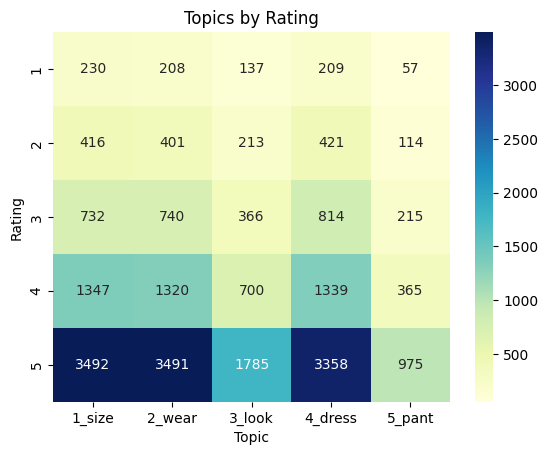

In [343]:
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")  # Annotate cells with numbers, use a blue color map

plt.title('Topics by Rating')  # Title of the heatmap
plt.ylabel('Rating')  # Y-axis label
plt.xlabel('Topic')  # X-axis label

plt.show()  # Display the heatmap

We see there is very little accuracy between the ratings and topic we are 3300 out of 23465 (14.06%) that are "predicted" correctly.

### Predicting LDA Topic using RF Classifer

Being that I couldn't come up with any reasonable ways to take the topics that were generated, I took the topics and the created a classifier from the 5 topics that were generated by the LDA model and optimized an RF model on these topics.

| Type | Score (Train) | Score Test |
|---|---|--- |
| unbalanced  | 0.579 | 0.58 |
| balanced (SMOTE)  | 0.88| 0.61|


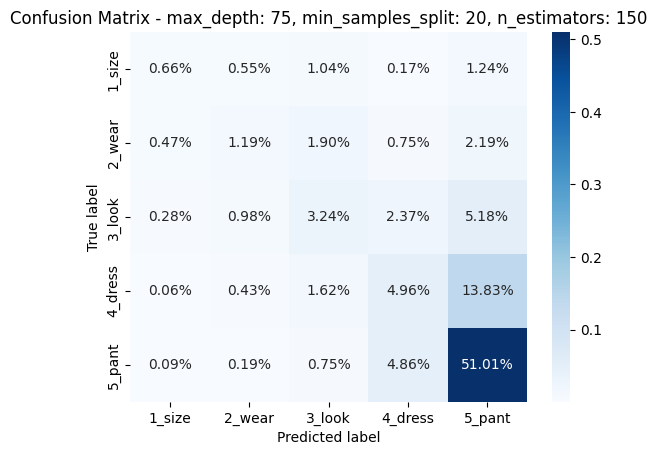

In [353]:

cm_unbal_review = confusion_matrix(X_test_res_review_balanced['y_test'], X_test_res_review_balanced['y_pred'])

cm_unbal_pct_review = (cm_unbal_review.astype('float') / np.sum(cm_unbal_review))

sns.heatmap(cm_unbal_pct_review, annot=True, fmt=".2%",   cmap="Blues",
            xticklabels=["1_size", "2_wear", "3_look", "4_dress", "5_pant"],
            yticklabels=["1_size", "2_wear", "3_look", "4_dress", "5_pant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - max_depth: 75, min_samples_split: 20, n_estimators: 150')
plt.show()

## Discussion
There are a number of new methods that I have yet to use that I have tried to implement in the following project. At the end of the day, the ability to be able to predict the topic of a review can be powerful in any business operation or way to parse through large volumes of data. In this case, marketing would find this information helpful to be able to purposefully make insights into the clothing lines. Some of the decisions they can make are as follows:

### Multi-LDA / Coherence Metric
This also was a new method for me, and I find it an interesting optimization metric that I hope I'll be able to use at a later date. It would have done me well to know of it in an earlier project for another class.

### SMOTE Rebalancing Impact

I know that rebalancing a dataset is important, in this case it did an increase the accuracy of the model.


### Ways to Improve the model

In a sense, I wish there was much more time to be alloted than 6 hrs for the following project. Much of the work that could still be done is fine tuning the feature set and running through more models but a few of the things that I would do.

* Implement more features, only using the review to come up with the model will improve the performance of the model
* Try other methods such as LogisticRegression and other Muliclassifer models
* Run a SearchGrid on a larger subspace and then use ensembles of the models to see if we can further increase the accuracy.
* Emphasize the role of cross-validation in assessing model performance more reliably, especially in the context of imbalanced datasets.
* Suggest extending the hyperparameter tuning process, possibly using more sophisticated methods like Bayesian optimization, to efficiently explore the hyperparameter space and find optimal settings.


## Conclusion

Overall, the project is an interesting one and I had a few insights from going through the process of generating this report. Much of the work that is done here could have much more improvement. I should have ran my models on smaller datasets so that I could get through a larger grid of searching and work at further refining some of the features of the data.


## References
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html